# Importing libraries


In [73]:
import graspologic
# set the environment path to find Recommenders
%load_ext autoreload
%autoreload 2
import random
import sys
from pyspark.ml.recommendation import ALS
import pyspark.sql.functions as F
from pyspark.sql.types import FloatType, IntegerType, LongType, StructType, StructField
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from pyspark.ml.feature import HashingTF, CountVectorizer, VectorAssembler
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import sys
import os
import json
import seaborn as sns
import pyspark
import torch
from tqdm import tqdm 
import fastai
import tensorflow as tf
tf.get_logger().setLevel('ERROR') # only show error messages
import surprise

from recommenders.utils.general_utils import get_number_processors
from recommenders.utils.gpu_utils import get_cuda_version, get_cudnn_version
from recommenders.datasets import movielens
from recommenders.datasets.python_splitters import python_stratified_split

from benchmark_utils import *
from recommenders.utils.timer import Timer
from recommenders.datasets import movielens
from recommenders.datasets.spark_splitters import spark_random_split
from recommenders.evaluation.spark_evaluation import SparkRankingEvaluation, SparkDiversityEvaluation
from recommenders.utils.spark_utils import start_or_get_spark

from pyspark.sql.window import Window
import pyspark.sql.functions as F
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print("System version: {}".format(sys.version))
print("Spark version: {}".format(pyspark.__version__))
print("Pandas version: {}".format(pd.__version__))
print("PySpark version: {}".format(pyspark.__version__))
print("Surprise version: {}".format(surprise.__version__))
print("PyTorch version: {}".format(torch.__version__))
print("Fast AI version: {}".format(fastai.__version__))
print("Cornac version: {}".format(cornac.__version__))
print("Tensorflow version: {}".format(tf.__version__))
print("CUDA version: {}".format(get_cuda_version()))
print("CuDNN version: {}".format(get_cudnn_version()))
n_cores = get_number_processors()
print("Number of cores: {}".format(n_cores))
from graspologic.simulations import mmsbm, sbm
from graspologic.plot import heatmap
from scipy.stats import poisson

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
System version: 3.9.12 (main, Mar 26 2022, 15:51:15) 
[Clang 13.1.6 (clang-1316.0.21.2)]
Spark version: 3.2.1
Pandas version: 1.4.2
PySpark version: 3.2.1
Surprise version: 1.1.1
PyTorch version: 1.11.0
Fast AI version: 2.5.6
Cornac version: 1.14.2
Tensorflow version: 2.8.0
CUDA version: No CUDA in this machine
CuDNN version: No CUDNN in this machine
Number of cores: 12


# Generating Synthetic Data and Movie Lens Data

In this section we will build synthetic data for testing our recommendation algorithms.

The main idea is to artificially build different group of individual and define probability of being drawn by certain item over others. We suppose for now that we have two groups: group A and group B. Members of group A and group B are interested in specific activities with a specific probability that we preliminary define. For example, a member of group A can be into racing cars with a probability of $p^A_\text{car}$ while a member of group B has a smaller probability equal to $p^B_\text{car}$. We suppose that we have up to $K$ type of items and $M$ different groups of identical population and we generate a stochastic block modelling to generate the different group. When we identify that a user is drawn to a specific item, we draw a Poisson distribution of parameters equal to 4. On the other hand, if the user has no interest, we draw a Poisson distribution of parameters equal to 2. At the end of the process, we obtain an artificial rating matrix that captures different interest present in the population 

8


,UserID,MovieID,Rating,Category,age
0,0,0,1.0,0,10
1,0,1,1.5,0,30
2,0,2,2.5,0,30
3,0,3,1.0,0,30
4,0,4,6.5,0,45
...,...,...,...,...,...
74995,299,245,0.0,2,40
74996,299,246,2.5,2,40
74997,299,247,1.5,2,35
74998,299,248,0.5,2,25


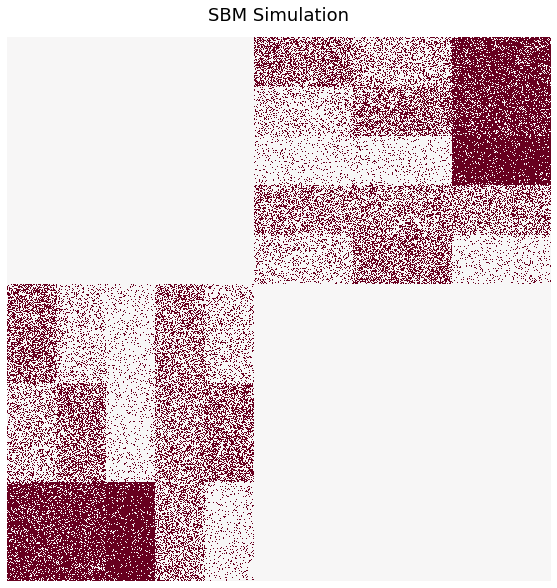

In [109]:

# Building data according to a certain distribution of iteration data. N

rng = np.random.default_rng(123)
number_of_categories = 5
n_of_categories = 50
n_of_items = 100
number_of_items = 3
n = [n_of_categories] * number_of_categories
n.extend([n_of_items]*number_of_items)
print(len(n))
# p = np.array([[0, 0, 0, 0, 0.8, 0.2, 0.2],
#               [0, 0, 0, 0, 0.8, 0.8, 0.2],
#               [0, 0, 0, 0, 0.2, 0.8, 0.8],
#               [0, 0, 0, 0, 0.2, 0.2, 0.8],
#               [0.8, 0.8, 0.2, 0.2, 0, 0, 0],
#               [0, 0.8, 0.8, 0, 0, 0, 0],
#               [0.2, 0.2, 0.8, 0.8, 0, 0, 0]])
# p = 
p = np.array([[0.5,0.3,0.8],
             [0.2, 0.5,0.8],
             [0.1, 0.1,0.9],
             [0.4, 0.4,0.4],
             [0.2, 0.5,0.1],
             ])

list_of_array = np.zeros((number_of_categories+number_of_items,number_of_categories+number_of_items))
for i in range(number_of_categories,number_of_categories+number_of_items):
    for j in range(0,number_of_categories):
        list_of_array[i][j] = p[j][i-number_of_categories]
        list_of_array[j][i] = p[j][i-number_of_categories]
G_sbm = sbm(n, list_of_array, directed=True, loops=False)
heatmap(G_sbm, cbar=False, title='SBM Simulation');
# from numpy.random import normal, poisson

rating = []
for i in range(number_of_categories*n_of_categories,G_sbm.shape[0]):
    for j in range(0,number_of_categories*n_of_categories):
        if G_sbm[i][j] == 0:
            val = poisson.rvs(mu=3, size=1)
            rating.append([i-number_of_categories*n_of_categories,j,val[0]/2.0, int((i-number_of_categories*n_of_categories)/n_of_items)])
        else:
            val = poisson.rvs(mu=8, size=1)
            rating.append([i-number_of_categories*n_of_categories,j,val[0]/2.0, int((i-number_of_categories*n_of_categories)/n_of_items)])
df_with_poisson = pd.DataFrame(rating,columns = ['UserID','MovieID','Rating','Category'])
putting_age_into_bins = range(10,80,5)
random_sample = list(np.random.normal(35, 10, df_with_poisson.shape[0]))
ages = []
for val in random_sample:
    age = min(putting_age_into_bins, key=lambda x:abs(x-val))
    ages.append(age)
df_with_poisson['age'] = ages
df_with_poisson

In [110]:
from collections import Counter
def creating_masked_entries(nrow,ncol,bias_representation,length_of_people):
    mask = []
    bias_representation = [0.1,0.05,0.5,0.2,0.15]
    bias_representation_cum = np.cumsum(bias_representation, dtype=float)
    ks = []
    success = 0
    mask_index = []
    for i in tqdm(range(nrow)):
        rand_val = random.random()
        print(rand_val)
        for j in range(ncol):
            k = 0 
            while bias_representation_cum[k] < random.random():
                k +=1 
                ks.append(k-1)
            if random.random() < bias_representation[k]*2*rand_val:
                mask.append(1)
                success +=1 
                mask_index.append((i,j))
            else:
                mask.append(0)
    mask = np.array(mask)
    mask = mask.reshape((nrow,ncol))
    print(Counter(ks))
    print(success)
    return mask_index
#     for i in range(nrow):
#         for j in range(ncol):
            
#     mask = []
#     distributions = []
#     for i in range(nrow):
#         for j in range(ncol):
#             distributions.append(i * ncol)
#     for i in tqdm(range(nrow)):
#         for j in range(ncol):
#             threshold_discarding = distributions[i * nrow + j] / float(nrow * ncol)
#             if random.random() > threshold_discarding:
#                 mask.append(1)
#             else:
#                 mask.append(0)
#     mask = np.array(mask)
#     mask = mask.reshape((nrow, ncol))
#     return mask

# masked = creating_masked_entries(number_of_categories*n_of_categories,n_of_users*number_of_items,[0.1,0.05,0.5,0.2,0.15],n)
masked = creating_masked_entries(df_with_poisson['UserID'].nunique(),df_with_poisson['MovieID'].nunique(),[0.1,0.05,0.5,0.2,0.15],n)
n

100%|██████████| 300/300 [00:00<00:00, 3180.76it/s]

0.09778133163321856
0.2526355718178339
0.019312575851090474
0.5878186620911448
0.100757550065671
0.02969707126557608
0.5245494978569871
0.6775477370754864
0.26689633191798956
0.2896153376806776
0.7327026322985681
0.22645182693262
0.7555491832708349
0.20847364483431818
0.20371792783022968
0.2713394645591114
0.15562401843351203
0.925751597681267
0.26049107697691354
0.17866891663588558
0.6208566317095712
0.333654131888927
0.6666308875074549
0.92126477746533
0.08248929865988164
0.4567886027030571
0.9249323187636507
0.9793544633008306
0.9453283542105873
0.8616594195711069
0.38723020984751344
0.14370367310910714
0.5807239946002273
0.22218687726409136
0.9229775426644437
0.8205552675581695
0.5975586390036732
0.7434706036704307
0.5582412845750976
0.6702931760750211
0.7514419380125956
0.39196719465618435
0.6632194991270206
0.7139889623443181
0.24798940560026528
0.6312163397735212
0.22374555756889458
0.9493486277612727
0.2839222726740561
0.6767886767281619
0.7546922029388204
0.7872878459028849
0.

[50, 50, 50, 50, 50, 100, 100, 100]

In [111]:
df_with_poisson[df_with_poisson['MovieID']==2]['UserID']

2          0
252        1
502        2
752        3
1002       4
        ... 
73752    295
74002    296
74252    297
74502    298
74752    299
Name: UserID, Length: 300, dtype: int64

In [112]:
# df_with_poisson.head()
restricted_df = []
for (i,j) in tqdm(masked):
#         if masked[i,j] == 1:
#             df_with_poisson[df_with_poisson['UserID']==i&&df_with_poisson['MovieID']==j]
    restricted_df.append(df_with_poisson[(df_with_poisson['UserID']==i)&(df_with_poisson['MovieID']==j)])

#         df_with_poisson[df_with_poisson['UserID']==i&df_with_poisson['MovieID']==i]
restricted_df = pd.concat(restricted_df)

100%|██████████| 23155/23155 [00:10<00:00, 2131.32it/s]


In [146]:
restricted_df

,UserID,MovieID,Rating,Category,age
2,0,2,2.5,0,30
3,0,3,1.0,0,30
25,0,25,1.0,0,40
35,0,35,1.5,0,40
43,0,43,2.0,0,15
...,...,...,...,...,...
74970,299,220,1.5,2,35
74972,299,222,1.5,2,40
74976,299,226,1.5,2,35
74984,299,234,2.5,2,50


Text(0.5, 1.0, 'Movie Rating Distribution')

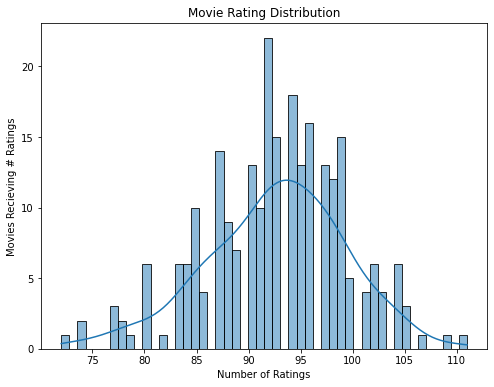

In [113]:
ratings_synthetic_mean_count = pd.DataFrame(restricted_df.groupby('MovieID')['Rating'].mean())
ratings_synthetic_mean_count['Rating_Counts'] = pd.DataFrame(restricted_df.groupby('MovieID')['Rating'].count())

plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
sns.histplot(data=ratings_synthetic_mean_count, x="Rating_Counts", kde=True, bins = 50)
plt.xlabel('Number of Ratings')
plt.ylabel('Movies Recieving # Ratings')
plt.title('Movie Rating Distribution')

<AxesSubplot:xlabel='age', ylabel='Count'>

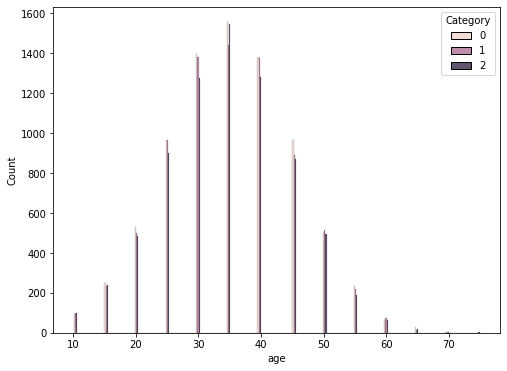

In [114]:
# df_with_poisson.groupby(['Category']).nunique()
plt.figure(figsize=(8,6))
sns.histplot(data = restricted_df, x = restricted_df['age'], hue = restricted_df['Category'],multiple="dodge", shrink=.8)

Text(0.5, 1.0, 'Movie Rating Distribution')

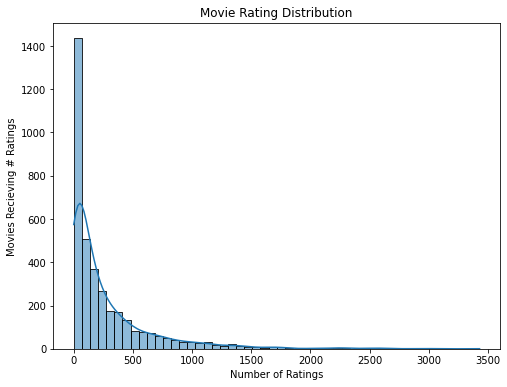

In [130]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
sns.histplot(data=ratings_mean_count, x="Rating_Counts", kde=True, bins = 50)
plt.xlabel('Number of Ratings')
plt.ylabel('Movies Recieving # Ratings')
plt.title('Movie Rating Distribution')

<Figure size 576x432 with 0 Axes>

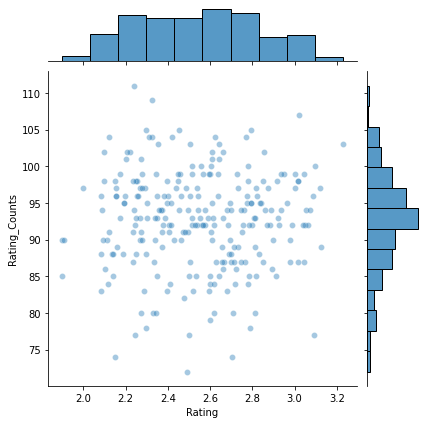

In [115]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
sns.jointplot(x='Rating', y='Rating_Counts', data=ratings_synthetic_mean_count, alpha=0.4)

<Figure size 576x432 with 0 Axes>

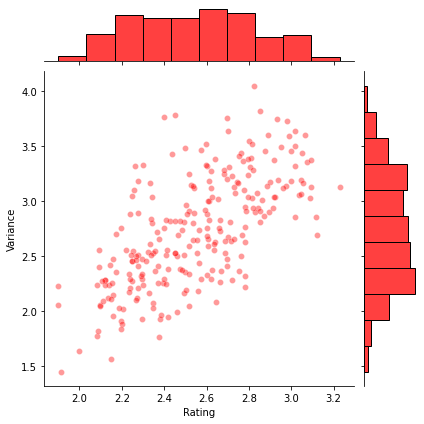

In [116]:
ratings_synthetic_mean_count['Variance'] = pd.DataFrame(restricted_df.groupby('MovieID')['Rating'].var())

plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
sns.jointplot(x='Rating', y='Variance', data=ratings_synthetic_mean_count, alpha=0.4,color='r')

In [117]:
path_to_data = "Data/ML1M/"
movies_df = pd.read_csv(path_to_data +
    'movies.dat',
    sep='::',
    names=['MovieID','Title','Genres'],
    engine='python',
    encoding='latin-1',
    header=None
)
users_df = pd.read_csv(path_to_data +
    'users.dat',
    sep='::',
    names=['UserID','Gender','Age', 'Occupation', 'zip-code'],
    engine='python',
    encoding='latin-1',
    header=None
)
ratings_df = pd.read_csv(path_to_data +
    'ratings.dat',
    sep='::',
    names=['UserID','MovieID','Rating', 'Timestamp'],
    parse_dates=['Timestamp'],
    engine='python',
    encoding='latin-1',
    header=None
)

In [118]:
def clean_movie_title(movie_title):
    if movie_title.split(" ")[-1].startswith("("):
        # remove year from the title, e.g. Toy Story (1995) --> Toy Story
        movie_title = (" ".join(movie_title.split(" ")[:-1])).strip()

    if movie_title.title().split(',')[-1].strip() in ['The', 'A']:
        # article + movie title, e.g. Saint, The --> The Saint
        movie_title = (movie_title.title().split(',')[-1].strip() + " " + " ".join(movie_title.title().split(',')[:-1])).strip()

    # otherwise, it was converting The Devil's Advocate to The Devil'S Advocate
    movie_title = movie_title.lower()
    return movie_title

column_item = ["movie_id_ml", "title", "release", "vrelease", "url", "unknown", 
                    "action", "adventure", "animation", "childrens", "comedy",
                   "crime", "documentary", "drama", "fantasy", "noir", "horror",
                   "musical", "mystery", "romance", "scifi", "thriller",
                   "war", "western"]

df_ML_movies = pd.read_csv('Data/ml-100k/u.item', delimiter='|', names=column_item, encoding = "ISO-8859-1") 
df_ML_movies = df_ML_movies.drop(columns=["vrelease"])
df_ML_movies["title"] = df_ML_movies["title"].apply(lambda row : clean_movie_title(row))   
df_ML_movies["release"] = df_ML_movies["release"].apply(lambda x : str(x).split("-")[-1])

# drop rows where movie starts with brackets, those are some strange names...
df_ML_movies = df_ML_movies[~df_ML_movies.title.str.startswith("(")]

# handle seven (se7en) movies, creating new rows containing the content of brackets
_df = df_ML_movies[df_ML_movies.title.str.contains("(", regex=False)]
# _df.title = _df.title.apply(lambda x: re.search(r'\((.*?)\)', x).group(1).strip() if re.search(r'\((.*?)\)', x) else x.strip())
df_ML_movies = df_ML_movies.append(_df)

print(df_ML_movies.shape)
print(df_ML_movies.dtypes)
df_ML_movies.head()

(1767, 23)
movie_id_ml     int64
title          object
release        object
url            object
unknown         int64
action          int64
adventure       int64
animation       int64
childrens       int64
comedy          int64
crime           int64
documentary     int64
drama           int64
fantasy         int64
noir            int64
horror          int64
musical         int64
mystery         int64
romance         int64
scifi           int64
thriller        int64
war             int64
western         int64
dtype: object


,movie_id_ml,title,release,url,unknown,action,adventure,animation,childrens,comedy,...,fantasy,noir,horror,musical,mystery,romance,scifi,thriller,war,western
0,1,toy story,1995,http://us.imdb.com/M/title-exact?Toy%20Story%20(1995),0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,goldeneye,1995,http://us.imdb.com/M/title-exact?GoldenEye%20(1995),0,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,four rooms,1995,http://us.imdb.com/M/title-exact?Four%20Rooms%20(1995),0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,get shorty,1995,http://us.imdb.com/M/title-exact?Get%20Shorty%20(1995),0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,5,copycat,1995,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [119]:
movie_ratings_df = pd.merge(movies_df, ratings_df, on='MovieID')
movie_ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000209 entries, 0 to 1000208
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   MovieID    1000209 non-null  int64 
 1   Title      1000209 non-null  object
 2   Genres     1000209 non-null  object
 3   UserID     1000209 non-null  int64 
 4   Rating     1000209 non-null  int64 
 5   Timestamp  1000209 non-null  object
dtypes: int64(3), object(3)
memory usage: 53.4+ MB


In [120]:
movie_ratings_users_df = pd.merge(
    movie_ratings_df,
    users_df,
    on='UserID'
)
Master_Data = movie_ratings_users_df.drop(
    ['zip-code', 'Timestamp'],
    axis=1
)
Master_Data.describe(include='all')


,MovieID,Title,Genres,UserID,Rating,Gender,Age,Occupation
count,1.000209e+06,1000209,1000209,1.000209e+06,1.000209e+06,1000209,1.000209e+06,1.000209e+06
unique,NaN,3706,301,NaN,NaN,2,NaN,NaN
top,NaN,American Beauty (1999),Comedy,NaN,NaN,M,NaN,NaN
freq,NaN,3428,116883,NaN,NaN,753769,NaN,NaN
mean,1.865540e+03,NaN,NaN,3.024512e+03,3.581564e+00,NaN,2.973831e+01,8.036138e+00
std,1.096041e+03,NaN,NaN,1.728413e+03,1.117102e+00,NaN,1.175198e+01,6.531336e+00
min,1.000000e+00,NaN,NaN,1.000000e+00,1.000000e+00,NaN,1.000000e+00,0.000000e+00
25%,1.030000e+03,NaN,NaN,1.506000e+03,3.000000e+00,NaN,2.500000e+01,2.000000e+00
50%,1.835000e+03,NaN,NaN,3.070000e+03,4.000000e+00,NaN,2.500000e+01,7.000000e+00
75%,2.770000e+03,NaN,NaN,4.476000e+03,4.000000e+00,NaN,3.500000e+01,1.400000e+01


<AxesSubplot:xlabel='Age', ylabel='Count'>

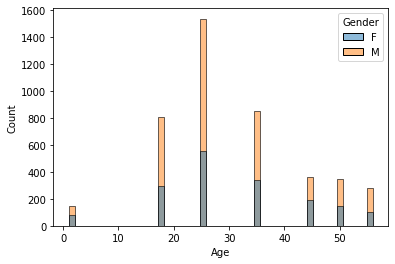

In [121]:
sns.histplot(data = users_df, x = users_df['Age'], hue = users_df['Gender'])

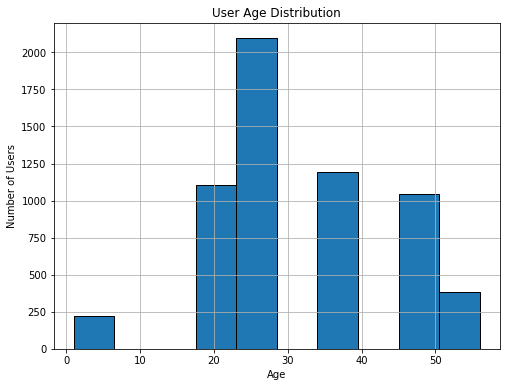

In [122]:
plt.figure(figsize=(8,6))
users_df.Age.hist()
plt.title('User Age Distribution')
plt.xlabel('Age')
plt.ylabel('Number of Users')
plt.show()

Text(0.5, 1.0, 'Movie Rating Distribution')

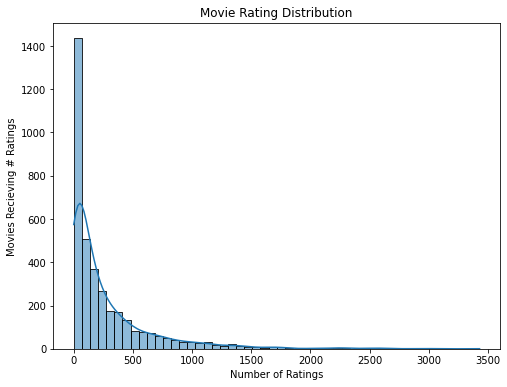

In [123]:
ratings_mean_count = pd.DataFrame(Master_Data.groupby('Title')['Rating'].mean())
ratings_mean_count['Rating_Counts'] = pd.DataFrame(Master_Data.groupby('Title')['Rating'].count())

plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
sns.histplot(data=ratings_mean_count, x="Rating_Counts", kde=True, bins = 50)
plt.xlabel('Number of Ratings')
plt.ylabel('Movies Recieving # Ratings')
plt.title('Movie Rating Distribution')

<Figure size 576x432 with 0 Axes>

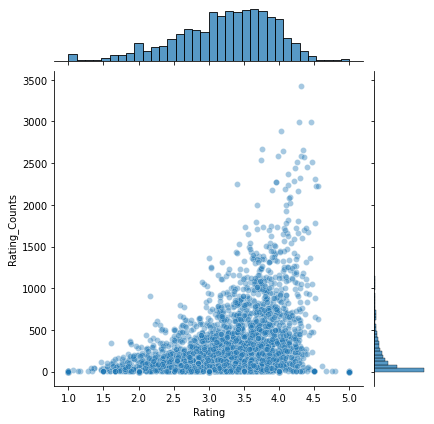

In [124]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
sns.jointplot(x='Rating', y='Rating_Counts', data=ratings_mean_count, alpha=0.4)

<Figure size 576x432 with 0 Axes>

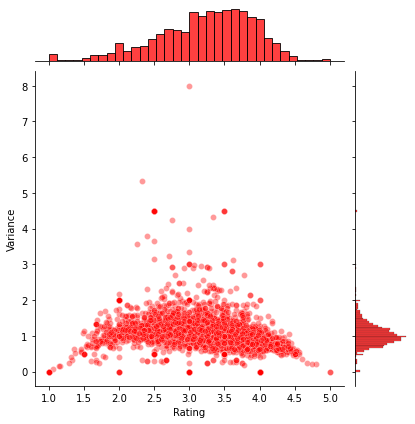

In [125]:
ratings_mean_count['Variance'] = pd.DataFrame(Master_Data.groupby('Title')['Rating'].var())

plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
sns.jointplot(x='Rating', y='Variance', data=ratings_mean_count, alpha=0.4,color='r')

<Figure size 576x432 with 0 Axes>

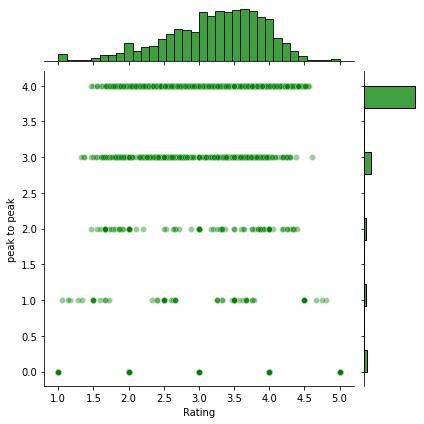

In [126]:
ratings_mean_count['peak to peak'] = pd.DataFrame(Master_Data.groupby('Title')['Rating'].agg(np.ptp))
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
sns.jointplot(x='Rating', y='peak to peak', data=ratings_mean_count, alpha=0.4,color='green')

Augmenting with meta-information from IMDB

In [127]:
columns_movies = ["movie_id", "title", "imdb_idx",
                  "movie_kind", "release", "imdb_id", "phonetic", "episode_id",
                  "season", "episode", "series_years", "md5"]

df_IMDb_movies = pd.read_csv('Data/tmdb_5000_movies.csv', delimiter=',',encoding = "ISO-8859-1", low_memory=False) 
# df_IMDb_movies = df_IMDb_movies.drop(columns=["imdb_idx", "imdb_id", "phonetic", "md5", "episode_id", "episode", "movie_kind", "season", "series_years"])
# df_IMDb_movies = df_IMDb_movies.dropna(subset=['release'])
# print(df_IMDb_movies)
# df_IMDb_movies["release"] = df_IMDb_movies["release"].apply(lambda x : str(int(x)).split("-")[-1])
# # we lowered in MovieLens as well
df_IMDb_movies = df_IMDb_movies.dropna(subset=["original_title"])
df_IMDb_movies["title"] = df_IMDb_movies["original_title"].apply(lambda x: x.lower())

# # drop rows where movie starts with brackets, those are some strange names...
df_IMDb_movies = df_IMDb_movies[~df_IMDb_movies.title.str.startswith("(")]

# # handle seven (se7en) movies, creating new rows containing the content of brackets
_df = df_IMDb_movies[df_IMDb_movies.title.str.contains("(", regex=False)]
# _df.title = _df.title.apply(lambda x: re.search(r'\((.*?)\)', x).group(1).strip() if re.search(r'\((.*?)\)', x) else x.strip())
df_IMDb_movies = df_IMDb_movies.append(_df)

print(df_IMDb_movies.dtypes)
print(df_IMDb_movies.shape)
df_IMDb_movies.head()

budget                    int64
genres                   object
homepage                 object
id                        int64
keywords                 object
original_language        object
original_title           object
overview                 object
popularity              float64
production_companies     object
production_countries     object
release_date             object
revenue                   int64
runtime                 float64
spoken_languages         object
status                   object
tagline                  object
title                    object
vote_average            float64
vote_count                int64
dtype: object
(4805, 20)


,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""name"": ""Fantasy""}, {""id"": 878, ""name"": ""Science Fiction""}]",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"": 2964, ""name"": ""future""}, {""id"": 3386, ""name"": ""space war""}, {""id"": 3388, ""name"": ""space colony""}, {""id"": 3679, ""name"": ""society""}, {""id"": 3801, ""name"": ""space travel""}, {""id"": 9685, ""name"": ""futuristic""}, {""id"": 9840, ""name"": ""romance""}, {""id"": 9882, ""name"": ""space""}, {""id"": 9951, ""name"": ""alien""}, {""id"": 10148, ""name"": ""tribe""}, {""id"": 10158, ""name"": ""alien planet""}, {""id"": 10987, ""name"": ""cgi""}, {""id"": 11399, ""name"": ""marine""}, {""id"": 13065, ""name"": ""soldier""}, {""id"": 14643, ""name"": ""battle""}, {""id"": 14720, ""name"": ""love affair""}, {""id"": 165...",en,Avatar,"In the 22nd century, a paraplegic Marine is dispatched to the moon Pandora on a unique mission, but becomes torn between following orders and protecting an alien civilization.",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289}, {""name"": ""Twentieth Century Fox Film Corporation"", ""id"": 306}, {""name"": ""Dune Entertainment"", ""id"": 444}, {""name"": ""Lightstorm Entertainment"", ""id"": 574}]","[{""iso_3166_1"": ""US"", ""name"": ""United States of America""}, {""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""}]",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso_639_1"": ""es"", ""name"": ""Espa\u00f1ol""}]",Released,Enter the World of Pandora.,avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""name"": ""Fantasy""}, {""id"": 28, ""name"": ""Action""}]",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""name"": ""drug abuse""}, {""id"": 911, ""name"": ""exotic island""}, {""id"": 1319, ""name"": ""east india trading company""}, {""id"": 2038, ""name"": ""love of one's life""}, {""id"": 2052, ""name"": ""traitor""}, {""id"": 2580, ""name"": ""shipwreck""}, {""id"": 2660, ""name"": ""strong woman""}, {""id"": 3799, ""name"": ""ship""}, {""id"": 5740, ""name"": ""alliance""}, {""id"": 5941, ""name"": ""calypso""}, {""id"": 6155, ""name"": ""afterlife""}, {""id"": 6211, ""name"": ""fighter""}, {""id"": 12988, ""name"": ""pirate""}, {""id"": 157186, ""name"": ""swashbuckler""}, {""id"": 179430, ""name"": ""aftercreditsstinger""}]",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, has come back to life and is headed to the edge of the Earth with Will Turner and Elizabeth Swann. But nothing is quite as it seems.",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""name"": ""Jerry Bruckheimer Films"", ""id"": 130}, {""name"": ""Second Mate Productions"", ""id"": 19936}]","[{""iso_3166_1"": ""US"", ""name"": ""United States of America""}]",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",pirates of the caribbean: at world's end,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""name"": ""Adventure""}, {""id"": 80, ""name"": ""Crime""}]",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name"": ""based on novel""}, {""id"": 4289, ""name"": ""secret agent""}, {""id"": 9663, ""name"": ""sequel""}, {""id"": 14555, ""name"": ""mi6""}, {""id"": 156095, ""name"": ""british secret service""}, {""id"": 158431, ""name"": ""united kingdom""}]",en,Spectre,"A cryptic message from Bondâs past sends him on a trail to uncover a sinister organization. While M battles politic

# Recommender system 


Set the default parameters.

In [128]:
# top k items to recommend
TOP_K = 100

# Select MovieLens data size: 100k, 1m, 10m, or 20m
MOVIELENS_DATA_SIZE = '100k'

# user, item column names
COL_USER="UserId"
COL_ITEM="MovieId"
COL_RATING="Rating"
COL_TITLE="Title"
COL_GENRE="Genre"

### 1. Set up Spark context

The following settings work well for debugging locally on VM - change when running on a cluster. We set up a giant single executor with many threads and specify memory cap. 

In [129]:
# the following settings work well for debugging locally on VM - change when running on a cluster
# set up a giant single executor with many threads and specify memory cap

spark = start_or_get_spark("ALS PySpark", memory="16g")
spark.conf.set("spark.sql.analyzer.failAmbiguousSelfJoin", "false")
spark.conf.set("spark.sql.crossJoin.enabled", "true")

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/04/18 21:18:14 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### 2. Download the MovieLens dataset

In [131]:
# Note: The DataFrame-based API for ALS currently only supports integers for user and item ids.
schema = StructType(
    (
        StructField(COL_USER, IntegerType()),
        StructField(COL_ITEM, IntegerType()),
        StructField(COL_RATING, FloatType()),
        StructField("Timestamp", LongType()),
    )
)

data = movielens.load_spark_df(spark, size=MOVIELENS_DATA_SIZE, schema=schema, title_col=COL_TITLE, genres_col=COL_GENRE)
data.show()

INFO:recommenders.datasets.download_utils:Downloading https://files.grouplens.org/datasets/movielens/ml-100k.zip
100%|██████████| 4.81k/4.81k [00:01<00:00, 3.93kKB/s]


+-------+------+------+---------+--------------------+------+
|MovieId|UserId|Rating|Timestamp|               Title| Genre|
+-------+------+------+---------+--------------------+------+
|     26|   138|   5.0|879024232|Brothers McMullen...|Comedy|
|     26|   224|   3.0|888104153|Brothers McMullen...|Comedy|
|     26|    18|   4.0|880129731|Brothers McMullen...|Comedy|
|     26|   222|   3.0|878183043|Brothers McMullen...|Comedy|
|     26|    43|   5.0|883954901|Brothers McMullen...|Comedy|
|     26|   201|   4.0|884111927|Brothers McMullen...|Comedy|
|     26|   299|   4.0|878192601|Brothers McMullen...|Comedy|
|     26|    95|   3.0|880571951|Brothers McMullen...|Comedy|
|     26|    89|   3.0|879459909|Brothers McMullen...|Comedy|
|     26|   361|   3.0|879440941|Brothers McMullen...|Comedy|
|     26|   194|   3.0|879522240|Brothers McMullen...|Comedy|
|     26|   391|   5.0|877399745|Brothers McMullen...|Comedy|
|     26|   345|   3.0|884993555|Brothers McMullen...|Comedy|
|     26

#### Split the data using the Spark random splitter provided in utilities

In [132]:
train_df, test_df = spark_random_split(data.select(COL_USER, COL_ITEM, COL_RATING), ratio=0.75, seed=123)
print ("N train_df", train_df.cache().count())
print ("N test_df", test_df.cache().count())

N train_df 75147
N test_df 24853


#### Get all possible user-item pairs

Note: We assume that training data contains all users and all catalog items. 

In [133]:
users = train_df.select(COL_USER).distinct()
items = train_df.select(COL_ITEM).distinct()
user_item = users.crossJoin(items)

### 3. Statistically investigate the property of movie lens 

### 3. Train a couple of recommender systems on the training data and get the top-k recommendations for our testing data

To predict movie ratings, we use the rating data in the training set as users' explicit feedback. The hyperparameters used in building the model are referenced from [here](http://mymedialite.net/examples/datasets.html). We do not constrain the latent factors (`nonnegative = False`) in order to allow for both positive and negative preferences towards movies.

#### We explictly build ALS to illustrate some key ideas and concepts

In [134]:
header = {
    "userCol": COL_USER,
    "itemCol": COL_ITEM,
    "ratingCol": COL_RATING,
}


als = ALS(
    rank=10,
    maxIter=15,
    implicitPrefs=False,
    regParam=0.05,
    coldStartStrategy='drop',
    nonnegative=False,
    seed=42,
    **header
)

In [135]:
with Timer() as train_time:
    model = als.fit(train_df)

print("Took {} seconds for training.".format(train_time.interval))

22/04/18 21:20:05 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/04/18 21:20:05 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
22/04/18 21:20:05 WARN InstanceBuilder$NativeLAPACK: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


Took 5.9252332510004635 seconds for training.


Generate similar plots as the earlier one to understand performance of the suggestions

In [136]:
# Score all user-item pairs
dfs_pred = model.transform(user_item)

# Remove seen items.
dfs_pred_exclude_train = dfs_pred.alias("pred").join(
    train_df.alias("train"),
    (dfs_pred[COL_USER] == train_df[COL_USER]) & (dfs_pred[COL_ITEM] == train_df[COL_ITEM]),
    how='outer'
)

top_all = dfs_pred_exclude_train.filter(dfs_pred_exclude_train["train.Rating"].isNull()) \
    .select('pred.' + COL_USER, 'pred.' + COL_ITEM, 'pred.' + "prediction")

print(top_all.count())

window = Window.partitionBy(COL_USER).orderBy(F.col("prediction").desc())
top_k_reco = top_all.select("*", F.row_number().over(window).alias("rank")).filter(F.col("rank") <= TOP_K).drop("rank")

print(top_k_reco.count())


22/04/18 21:20:07 WARN Column: Constructing trivially true equals predicate, 'UserId#6 = UserId#6'. Perhaps you need to use aliases.


1464772


94300


In [127]:
pred_rating = dfs_pred.toPandas()

,UserId,MovieId,prediction
0,148,463,4.168110
1,148,1591,3.780245
2,148,496,3.525092
3,148,1238,3.493942
4,148,1342,2.688851
...,...,...,...
1539914,147,517,4.167564
1539915,147,1138,2.506682
1539916,147,422,2.615132
1539917,147,1413,1.352020


In [137]:
Master_Data

,MovieID,Title,Genres,UserID,Rating,Gender,Age,Occupation
0,1,Toy Story (1995),Animation|Children's|Comedy,1,5,F,1,10
1,48,Pocahontas (1995),Animation|Children's|Musical|Romance,1,5,F,1,10
2,150,Apollo 13 (1995),Drama,1,5,F,1,10
3,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi,1,4,F,1,10
4,527,Schindler's List (1993),Drama|War,1,5,F,1,10
...,...,...,...,...,...,...,...,...
1000204,3513,Rules of Engagement (2000),Drama|Thriller,5727,4,M,25,4
1000205,3535,American Psycho (2000),Comedy|Horror|Thriller,5727,2,M,25,4
1000206,3536,Keeping the Faith (2000),Comedy|Romance,5727,5,M,25,4
1000207,3555,U-571 (2000),Action|Thriller,5727,3,M,25,4


In [138]:
users = train_df.select(als.getUserCol()).distinct().limit(3)

dfs_rec_subset = model.recommendForUserSubset(users, 10)
dfs_rec_subset.show(10)

+------+--------------------+
|UserId|     recommendations|
+------+--------------------+
|   833|[{1368, 5.3286886...|
|   243|[{1176, 5.052174}...|
|   148|[{1142, 5.721592}...|
+------+--------------------+



In the movie recommendation use case, recommending movies that have been rated by the users does not make sense. Therefore, the rated movies are removed from the recommended items.

In order to achieve this, we recommend all movies to all users, and then remove the user-movie pairs that exist in the training dataset.

### 3 Build a bunch of standard recommender system

In [140]:
# fix random seeds to make sure out runs are reproducible
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
environments = {
    "als": "pyspark",
    "sar": "python_cpu",
    "svd": "python_cpu",
    "fastai": "python_cpu",
    "ncf": "python_cpu",
    "bpr": "python_cpu",
    "bivae": "python_cpu",
    "lightgcn": "python_cpu",
}

metrics = {
    "als": ["rating", "ranking"],
    "sar": ["ranking"],
    "svd": ["rating", "ranking"],
    "fastai": ["rating", "ranking"],
    "ncf": ["ranking"],
    "bpr": ["ranking"],
    "bivae": ["ranking"],
    "lightgcn": ["ranking"]
}

In [141]:
als_params = {
    "rank": 10,
    "maxIter": 15,
    "implicitPrefs": False,
    "alpha": 0.1,
    "regParam": 0.05,
    "coldStartStrategy": "drop",
    "nonnegative": False,
    "userCol": DEFAULT_USER_COL,
    "itemCol": DEFAULT_ITEM_COL,
    "ratingCol": DEFAULT_RATING_COL,
}

sar_params = {
    "similarity_type": "jaccard",
    "time_decay_coefficient": 30,
    "time_now": None,
    "timedecay_formula": True,
    "col_user": DEFAULT_USER_COL,
    "col_item": DEFAULT_ITEM_COL,
    "col_rating": DEFAULT_RATING_COL,
    "col_timestamp": DEFAULT_TIMESTAMP_COL,
}

svd_params = {
    "n_factors": 150,
    "n_epochs": 15,
    "lr_all": 0.005,
    "reg_all": 0.02,
    "random_state": SEED,
    "verbose": False
}

fastai_params = {
    "n_factors": 40,
    "y_range": [0, 5.5],
    "wd": 1e-1,
    "max_lr": 5e-3,
    "epochs": 15
}

ncf_params = {
    "model_type": "NeuMF",
    "n_factors": 4,
    "layer_sizes": [16, 8, 4],
    "n_epochs": 15,
    "batch_size": 1024,
    "learning_rate": 1e-3,
    "verbose": 10
}

bpr_params = {
    "k": 200,
    "max_iter": 200,
    "learning_rate": 0.01,
    "lambda_reg": 1e-3,
    "seed": SEED,
    "verbose": False
}

bivae_params = {
    "k": 100,
    "encoder_structure": [200],
    "act_fn": "tanh",
    "likelihood": "pois",
    "n_epochs": 500,
    "batch_size": 1024,
    "learning_rate": 0.001,
    "seed": SEED,
    "use_gpu": True,
    "verbose": False
}

lightgcn_param = {
    "yaml_file": os.path.join("Data", "lightgcn.yaml"),
    "n_layers": 3,
    "batch_size": 1024,
    "epochs": 15,
    "learning_rate": 0.005,
    "eval_epoch": 5,
    "top_k": DEFAULT_K,
}

params = {
    "als": als_params,
    "sar": sar_params,
    "svd": svd_params,
    "fastai": fastai_params,
    "ncf": ncf_params,
    "bpr": bpr_params,
    "bivae": bivae_params,
    "lightgcn": lightgcn_param,
}
prepare_training_data = {
    "als": prepare_training_als,
    "sar": prepare_training_sar,
    "svd": prepare_training_svd,
    "fastai": prepare_training_fastai,
    "ncf": prepare_training_ncf,
    "bpr": prepare_training_cornac,
    "bivae": prepare_training_cornac,
    "lightgcn": prepare_training_lightgcn,
}
prepare_metrics_data = {
    "als": lambda train, test: prepare_metrics_als(train, test),
    "fastai": lambda train, test: prepare_metrics_fastai(train, test),
}
trainer = {
    "als": lambda params, data: train_als(params, data),
    "svd": lambda params, data: train_svd(params, data),
    "sar": lambda params, data: train_sar(params, data),
    "fastai": lambda params, data: train_fastai(params, data),
    "ncf": lambda params, data: train_ncf(params, data),
    "bpr": lambda params, data: train_bpr(params, data),
    "bivae": lambda params, data: train_bivae(params, data),
    "lightgcn": lambda params, data: train_lightgcn(params, data),
}
rating_predictor = {
    "als": lambda model, test: predict_als(model, test),
    "svd": lambda model, test: predict_svd(model, test),
    "fastai": lambda model, test: predict_fastai(model, test),
}
ranking_predictor = {
    "als": lambda model, test, train: recommend_k_als(model, test, train),
    "sar": lambda model, test, train: recommend_k_sar(model, test, train),
    "svd": lambda model, test, train: recommend_k_svd(model, test, train),
    "fastai": lambda model, test, train: recommend_k_fastai(model, test, train),
    "ncf": lambda model, test, train: recommend_k_ncf(model, test, train),
    "bpr": lambda model, test, train: recommend_k_cornac(model, test, train),
    "bivae": lambda model, test, train: recommend_k_cornac(model, test, train),
    "lightgcn": lambda model, test, train: recommend_k_lightgcn(model, test, train),
}
rating_evaluator = {
    "als": lambda test, predictions: rating_metrics_pyspark(test, predictions),
    "svd": lambda test, predictions: rating_metrics_python(test, predictions),
    "fastai": lambda test, predictions: rating_metrics_python(test, predictions)
}

ranking_evaluator = {
    "als": lambda test, predictions, k: ranking_metrics_pyspark(test, predictions, k),
    "sar": lambda test, predictions, k: ranking_metrics_python(test, predictions, k),
    "svd": lambda test, predictions, k: ranking_metrics_python(test, predictions, k),
    "fastai": lambda test, predictions, k: ranking_metrics_python(test, predictions, k),
    "ncf": lambda test, predictions, k: ranking_metrics_python(test, predictions, k),
    "bpr": lambda test, predictions, k: ranking_metrics_python(test, predictions, k),
    "bivae": lambda test, predictions, k: ranking_metrics_python(test, predictions, k),
    "lightgcn": lambda test, predictions, k: ranking_metrics_python(test, predictions, k),
}


def generate_summary(data, algo, k, train_time, time_rating, rating_metrics, time_ranking, ranking_metrics):
    summary = {"Data": data, "Algo": algo, "K": k, "Train time (s)": train_time, "Predicting time (s)": time_rating,
               "Recommending time (s)": time_ranking}
    if rating_metrics is None:
        rating_metrics = {
            "RMSE": np.nan,
            "MAE": np.nan,
            "R2": np.nan,
            "Explained Variance": np.nan,
        }
    if ranking_metrics is None:
        ranking_metrics = {
            "MAP": np.nan,
            "nDCG@k": np.nan,
            "Precision@k": np.nan,
            "Recall@k": np.nan,
        }
    summary.update(rating_metrics)
    summary.update(ranking_metrics)
    return summary

In [150]:
%%time

data_sizes = ["100k"]  # Movielens data size: 100k, 1m, 10m, or 20m
algorithms = ["als", "svd", "sar"]
#               "ncf", "bpr", "bivae", "lightgcn"]
# algorithms = [ "lightgcn"]

# algorithms = ['ncf']
# For each data size and each algorithm, a recommender is evaluated.
cols = ["Data", "Algo", "K", "Train time (s)", "Predicting time (s)", "RMSE", "MAE", "R2", "Explained Variance",
        "Recommending time (s)", "MAP", "nDCG@k", "Precision@k", "Recall@k"]
df_results = pd.DataFrame(columns=cols)

for data_size in data_sizes:
    # Load the dataset
    df = movielens.load_pandas_df(
        size=data_size,
        header=[DEFAULT_USER_COL, DEFAULT_ITEM_COL, DEFAULT_RATING_COL, DEFAULT_TIMESTAMP_COL]
    )
    print("Size of Movielens {}: {}".format(data_size, df.shape))

    # Split the dataset
    df_train, df_test = python_stratified_split(df,
                                                ratio=0.75,
                                                min_rating=1,
                                                filter_by="item",
                                                col_user=DEFAULT_USER_COL,
                                                col_item=DEFAULT_ITEM_COL
                                                )

    # Loop through the algos
    for algo in algorithms:
        print(f"\nComputing {algo} algorithm on Movielens {data_size}")
        print(df_train,df_test)
        # Data prep for training set
        if algo == 'ncf':
            train = prepare_training_data.get(algo, lambda x,y: (x,y))(train_file,leave_one_out_test_file)
        else:
            train = prepare_training_data.get(algo, lambda x, y: (x, y))(df_train, df_test)

        # Get model parameters
        model_params = params[algo]

        # Train the model
        model, time_train = trainer[algo](model_params, train)
        print(f"Training time: {time_train}s")

        # Predict and evaluate
        train, test = prepare_metrics_data.get(algo, lambda x, y: (x, y))(df_train, df_test)
        print(model.recommendForAllUsers(3).show())
        if "rating" in metrics[algo]:
            # Predict for rating
            preds, time_rating = rating_predictor[algo](model, test)
            print(f"Rating prediction time: {time_rating}s")

            # Evaluate for rating
            ratings = rating_evaluator[algo](test, preds)
        else:
            ratings = None
            time_rating = np.nan

        if "ranking" in metrics[algo]:
            # Predict for ranking
            top_k_scores, time_ranking = ranking_predictor[algo](model, test, train)
            print(f"Ranking prediction time: {time_ranking}s")

            # Evaluate for rating
            rankings = ranking_evaluator[algo](test, top_k_scores, DEFAULT_K)
        else:
            rankings = None
            time_ranking = np.nan
        generate_recommendations
        # Record results
        summary = generate_summary(data_size, algo, DEFAULT_K, time_train, time_rating, ratings, time_ranking, rankings)
        df_results.loc[df_results.shape[0] + 1] = summary

print("\nComputation finished")

INFO:recommenders.datasets.download_utils:Downloading https://files.grouplens.org/datasets/movielens/ml-100k.zip
100%|██████████| 4.81k/4.81k [00:00<00:00, 5.63kKB/s]


Size of Movielens 100k: (100000, 4)

Computing als algorithm on Movielens 100k
       userID  itemID  rating  timestamp
65143      25       1     5.0  885853415
10563      96       1     5.0  884403574
74221     665       1     4.0  884290491
73482     660       1     3.0  891406276
36922     441       1     5.0  891035468
...       ...     ...     ...        ...
75323     863    1678     1.0  889289570
67302     863    1679     3.0  889289491
80394     863    1680     2.0  889289570
92329     896    1681     3.0  887160722
95376     916    1682     3.0  880845755

[75066 rows x 4 columns]        userID  itemID  rating  timestamp
63583     602       1     4.0  888638547
39989     649       1     5.0  891440235
87422     576       1     4.0  886985079
33777     162       1     4.0  877635819
18263     374       1     4.0  880392992
...       ...     ...     ...        ...
90815     918    1639     5.0  891987571
95080     901    1643     5.0  877130473
96602     756    1652     1.0  874

Training time: 4.3071s


+------+--------------------+
|userID|     recommendations|
+------+--------------------+
|     1|[{50, 5.138444}, ...|
|     3|[{875, 5.37082}, ...|
|     5|[{793, 5.5118837}...|
|     6|[{661, 4.72377}, ...|
|    12|[{316, 5.5055866}...|
|    13|[{1245, 5.432502}...|
|    15|[{165, 5.2974787}...|
|    16|[{115, 5.826298},...|
|    19|[{1405, 5.3056817...|
|    20|[{1120, 5.863245}...|
|    22|[{50, 5.4712467},...|
|    26|[{127, 4.1995068}...|
|    27|[{1449, 4.760481}...|
|    28|[{183, 5.09541}, ...|
|    31|[{1463, 5.4643025...|
|    34|[{1282, 7.8404794...|
|    40|[{1313, 4.816779}...|
|    41|[{1449, 4.6596527...|
|    43|[{318, 4.9160147}...|
|    44|[{1268, 5.0615582...|
+------+--------------------+
only showing top 20 rows

None
Rating prediction time: 0.0348s


22/04/18 21:55:45 WARN Column: Constructing trivially true equals predicate, 'userID#5303 = userID#5303'. Perhaps you need to use aliases.


Ranking prediction time: 0.1196s


NameError: name 'generate_recommendations' is not defined

### Investigate recommender output for a user of interest

### 4. Random Recommender

We define a recommender which randomly recommends unseen items to each user. 

In [143]:
# random recommender
window = Window.partitionBy(COL_USER).orderBy(F.rand())

# randomly generated recommendations for each user
pred_df = (
  train_df
  # join training data with all possible user-item pairs (seen in training)
  .join(user_item,
        on=[COL_USER, COL_ITEM],
        how="right"
  )
  # get user-item pairs that were not seen in the training data
  .filter(F.col(COL_RATING).isNull())
  # count items for each user (randomly sorting them)
  .withColumn("score", F.row_number().over(window))
  # get the top k items per user
  .filter(F.col("score") <= TOP_K)
  .drop(COL_RATING)
)

### 5. ALS vs Random Recommenders Performance Comparison

In [144]:
def get_ranking_results(ranking_eval):
    metrics = {
        "Precision@k": ranking_eval.precision_at_k(),
        "Recall@k": ranking_eval.recall_at_k(),
        "NDCG@k": ranking_eval.ndcg_at_k(),
        "Mean average precision": ranking_eval.map_at_k()
      
    }
    return metrics   

def get_diversity_results(diversity_eval):
    metrics = {
        "catalog_coverage":diversity_eval.catalog_coverage(),
        "distributional_coverage":diversity_eval.distributional_coverage(), 
        "novelty": diversity_eval.novelty(), 
        "diversity": diversity_eval.diversity(), 
        "serendipity": diversity_eval.serendipity()
    }
    return metrics 

In [145]:
def generate_summary(data, algo, k, ranking_metrics, diversity_metrics):
    summary = {"Data": data, "Algo": algo, "K": k}

    if ranking_metrics is None:
        ranking_metrics = {           
            "Precision@k": np.nan,
            "Recall@k": np.nan,            
            "nDCG@k": np.nan,
            "MAP": np.nan,
        }
    summary.update(ranking_metrics)
    summary.update(diversity_metrics)
    return summary

#### ALS Recommender Performance Results

In [68]:
als_ranking_eval = SparkRankingEvaluation(
    test_df, 
    top_all, 
    k = TOP_K, 
    col_user=COL_USER, 
    col_item=COL_ITEM,
    col_rating=COL_RATING, 
    col_prediction="prediction",
    relevancy_method="top_k"
)

als_ranking_metrics = get_ranking_results(als_ranking_eval)
top_all

DataFrame[UserId: int, MovieId: int, prediction: float]

In [14]:
als_diversity_eval = SparkDiversityEvaluation(
    train_df = train_df, 
    reco_df = top_k_reco,
    col_user = COL_USER, 
    col_item = COL_ITEM
)

als_diversity_metrics = get_diversity_results(als_diversity_eval)

In [15]:
als_results = generate_summary(MOVIELENS_DATA_SIZE, "als", TOP_K, als_ranking_metrics, als_diversity_metrics)

NameError: name 'als_diversity_metrics' is not defined

# Apply Diversity Metrics  
## -- Compare ALS and Random Recommenders on MovieLens (PySpark)

In this notebook, we demonstrate how to evaluate a recommender using metrics other than commonly used rating/ranking metrics.

Such metrics include:
- Coverage - We use following two metrics defined by \[Shani and Gunawardana\]:
 
    - (1) catalog_coverage, which measures the proportion of items that get recommended from the item catalog; 
    - (2) distributional_coverage, which measures how equally different items are recommended in the recommendations to all users.

- Novelty - A more novel item indicates it is less popular, i.e. it gets recommended less frequently.
We use the definition of novelty from \[Castells et al.\]

- Diversity - The dissimilarity of items being recommended.
We use a definition based on _intralist similarity_ by \[Zhang et al.]

- Serendipity - The "unusualness" or "surprise" of recommendations to a user.
We use a definition based on cosine similarity by \[Zhang et al.]

We evaluate the results obtained with two approaches: using the ALS recommender algorithm vs. a baseline of random recommendations. 
 - Matrix factorization by [ALS](https://spark.apache.org/docs/latest/api/python/_modules/pyspark/ml/recommendation.html#ALS) (Alternating Least Squares) is a well known collaborative filtering algorithm.
 - We also define a process which randomly recommends unseen items to each user. 
 - We show two options to calculate item-item similarity: (1) based on item co-occurrence count; and (2) based on item feature vectors.
 
The comparision results show that the ALS recommender outperforms the random recommender on ranking metrics (Precision@k, Recall@k, NDCG@k, and	Mean average precision), while the random recommender outperforms ALS recommender on diversity metrics. This is because ALS is optimized for estimating the item rating as accurate as possible, therefore it performs well on accuracy metrics including rating and ranking metrics. As a side effect, the items being recommended tend to be popular items, which are the items mostly sold or viewed. It leaves the [long-tail items](https://github.com/microsoft/recommenders/blob/main/GLOSSARY.md) having less chance to get introduced to the users. This is the reason why ALS is not performing as well as a random recommender on diversity metrics. 

From the algorithmic point of view, items in the tail suffer from the cold-start problem, making them hard for recommendation systems to use. However, from the business point of view, oftentimes the items in the tail can be highly profitable, since, depending on supply, business can apply a higher margin to them. Recommendation systems that optimize metrics like novelty and diversity, can help to find users willing to get these long tail items. Usually there is a trade-off between one type of metric vs. another. One should decide which set of metrics to optimize based on business scenarios.

**Coverage**

We define _catalog coverage_ as the proportion of items showing in all users’ recommendations: 
$$
\textrm{CatalogCoverage} = \frac{|N_r|}{|N_t|}
$$
where $N_r$ denotes the set of items in the recommendations (`reco_df` in the code below) and $N_t$ the set of items in the historical data (`train_df`).

_Distributional coverage_ measures how equally different items are recommended to users when a particular recommender system is used.
If  $p(i|R)$ denotes the probability that item $i$ is observed among all recommendation lists, we define distributional coverage as
$$
\textrm{DistributionalCoverage} = -\sum_{i \in N_t} p(i|R) \log_2 p(i)
$$
where 
$$
p(i|R) = \frac{|M_r (i)|}{|\textrm{reco_df}|}
$$
and $M_r (i)$ denotes the users who are recommended item $i$.



**Diversity**

Diversity represents the variety present in a list of recommendations.
_Intra-List Similarity_ aggregates the pairwise similarity of all items in a set. A recommendation list with groups of very similar items will score a high intra-list similarity. Lower intra-list similarity indicates higher diversity.
To measure similarity between any two items we use _cosine similarity_:
$$
\textrm{Cosine Similarity}(i,j)=  \frac{|M_t^{l(i,j)}|} {\sqrt{|M_t^{l(i)}|} \sqrt{|M_t^{l(j)}|} }
$$
where $M_t^{l(i)}$ denotes the set of users who liked item $i$ and $M_t^{l(i,j)}$ the users who liked both $i$ and $j$.
Intra-list similarity is then defined as 
$$
\textrm{IL} = \frac{1}{|M|} \sum_{u \in M} \frac{1}{\binom{N_r(u)}{2}} \sum_{i,j \in N_r (u),\, i<j} \textrm{Cosine Similarity}(i,j)
$$
where $M$ is the set of users and $N_r(u)$ the set of recommendations for user $u$. Finally, diversity is defined as
$$
\textrm{diversity} = 1 - \textrm{IL}
$$



**Novelty**

The novelty of an item is inverse to its _popularity_. If $p(i)$ represents the probability that item $i$ is observed (or known, interacted with etc.) by users, then  
$$
p(i) = \frac{|M_t (i)|} {|\textrm{train_df}|}
$$
where $M_t (i)$ is the set of users who have interacted with item $i$ in the historical data. 

The novelty of an item is then defined as
$$
\textrm{novelty}(i) = -\log_2 p(i)
$$
and the novelty of the recommendations across all users is defined as
$$
\textrm{novelty} = \sum_{i \in N_r} \frac{|M_r (i)|}{|\textrm{reco_df}|} \textrm{novelty}(i)
$$


**Serendipity**

Serendipity represents the “unusualness” or “surprise” of recommendations. Unlike novelty, serendipity encompasses the semantic content of items and can be imagined as the distance between recommended items and their expected contents (Zhang et al.) Lower cosine similarity indicates lower expectedness and higher serendipity.
We define the expectedness of an unseen item $i$ for user $u$ as the average similarity between every already seen item $j$ in the historical data and $i$:
$$
\textrm{expectedness}(i|u) = \frac{1}{|N_t (u)|} \sum_{j \in N_t (u)} \textrm{Cosine Similarity}(i,j)
$$
The serendipity of item $i$ is (1 - expectedness) multiplied by _relevance_, where relevance indicates whether the item turns out to be liked by the user or not. For example, in a binary scenario, if an item in `reco_df` is liked (purchased, clicked) in `test_df`, its relevance equals one, otherwise it equals zero. Aggregating over all users and items, the overall 
serendipity is defined as
$$
\textrm{serendipity} = \frac{1}{|M|} \sum_{u \in M_r}
\frac{1}{|N_r (u)|} \sum_{i \in N_r (u)} \big(1 - \textrm{expectedness}(i|u) \big) \, \textrm{relevance}(i)
$$


#### Random Recommender Performance Results

In [ ]:
random_ranking_eval = SparkRankingEvaluation(
    test_df,
    pred_df,
    col_user=COL_USER,
    col_item=COL_ITEM,
    col_rating=COL_RATING,
    col_prediction="score",
    k=TOP_K,
)

random_ranking_metrics = get_ranking_results(random_ranking_eval)

In [17]:
random_diversity_eval = SparkDiversityEvaluation(
    train_df = train_df, 
    reco_df = pred_df, 
    col_user = COL_USER, 
    col_item = COL_ITEM
)
  
random_diversity_metrics = get_diversity_results(random_diversity_eval)

In [ ]:
random_results = generate_summary(MOVIELENS_DATA_SIZE, "random", TOP_K, random_ranking_metrics, random_diversity_metrics)

#### Result Comparison

In [ ]:
cols = ["Data", "Algo", "K", "Precision@k", "Recall@k", "NDCG@k", "Mean average precision","catalog_coverage", "distributional_coverage","novelty", "diversity", "serendipity" ]
df_results = pd.DataFrame(columns=cols)

df_results.loc[1] = als_results 
df_results.loc[2] = random_results 

In [ ]:
df_results

#### Conclusion
The comparision results show that the ALS recommender outperforms the random recommender on ranking metrics (Precision@k, Recall@k, NDCG@k, and	Mean average precision), while the random recommender outperforms ALS recommender on diversity metrics. This is because ALS is optimized for estimating the item rating as accurate as possible, therefore it performs well on accuracy metrics including rating and ranking metrics. As a side effect, the items being recommended tend to be popular items, which are the items mostly sold or viewed. It leaves the long-tail less popular items having less chance to get introduced to the users. This is the reason why ALS is not performing as well as a random recommender on diversity metrics. 

### 6.  Calculate diversity metrics using item feature vector based item-item similarity
In the above section we calculate diversity metrics using item co-occurrence count based item-item similarity. In the scenarios when item features are available, we may want to calculate item-item similarity based on item feature vectors. In this section, we show how to calculate diversity metrics using item feature vector based item-item similarity.

In [21]:
# Get movie features "title" and "genres"
movies = (
    data.groupBy(COL_ITEM, COL_TITLE, COL_GENRE).count()
    .na.drop()  # remove rows with null values
    .withColumn(COL_GENRE, F.split(F.col(COL_GENRE), "\|"))  # convert to array of genres
    .withColumn(COL_TITLE, F.regexp_replace(F.col(COL_TITLE), "[\(),:^0-9]", ""))  # remove year from title
    .drop("count")  # remove unused columns
)

In [22]:
# tokenize "title" column
title_tokenizer = Tokenizer(inputCol=COL_TITLE, outputCol="title_words")
tokenized_data = title_tokenizer.transform(movies)

# remove stop words
remover = StopWordsRemover(inputCol="title_words", outputCol="text")
clean_data = remover.transform(tokenized_data).drop(COL_TITLE, "title_words")

In [23]:
# convert text input into feature vectors

# step 1: perform HashingTF on column "text"
text_hasher = HashingTF(inputCol="text", outputCol="text_features", numFeatures=1024)
hashed_data = text_hasher.transform(clean_data)

# step 2: fit a CountVectorizerModel from column "genres".
count_vectorizer = CountVectorizer(inputCol=COL_GENRE, outputCol="genres_features")
count_vectorizer_model = count_vectorizer.fit(hashed_data)
vectorized_data = count_vectorizer_model.transform(hashed_data)

# step 3: assemble features into a single vector
assembler = VectorAssembler(
    inputCols=["text_features", "genres_features"],
    outputCol="features",
)
feature_data = assembler.transform(vectorized_data).select(COL_ITEM, "features")

feature_data.show(10, False)

+-------+------------------------------------------------------------------------------------+
|MovieId|features                                                                            |
+-------+------------------------------------------------------------------------------------+
|29     |(1043,[158,269,1025,1026,1029,1031],[1.0,1.0,1.0,1.0,1.0,1.0])                      |
|26     |(1043,[54,139,1025],[1.0,1.0,1.0])                                                  |
|1677   |(1043,[260,902,1024],[1.0,1.0,1.0])                                                 |
|964    |(1043,[416,429,1024,1025],[1.0,1.0,1.0,1.0])                                        |
|474    |(1043,[112,302,329,517,540,787,933,1032,1034],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])|
|1258   |(1043,[114,799,1025,1028],[1.0,1.0,1.0,1.0])                                        |
|541    |(1043,[635,910,1026,1029],[1.0,1.0,1.0,1.0])                                        |
|1224   |(1043,[978,1024],[1.0,1.0])              

The *features* column is represented with a SparseVector object. For example, in the feature vector (1043,[128,544,1025],[1.0,1.0,1.0]), 1043 is the vector length, indicating the vector consisting of 1043 item features. The values at index positions 128,544,1025 are 1.0, and the values at other positions are all 0. 

In [24]:
als_eval = SparkDiversityEvaluation(
    train_df = train_df, 
    reco_df = top_k_reco,
    item_feature_df = feature_data, 
    item_sim_measure="item_feature_vector",
    col_user = COL_USER, 
    col_item = COL_ITEM
)

als_diversity=als_eval.diversity()
als_serendipity=als_eval.serendipity()
print(als_diversity)
print(als_serendipity)

0.8742459916963194
0.8891175823541189


In [25]:
random_eval = SparkDiversityEvaluation(
    train_df = train_df, 
    reco_df = pred_df, 
    item_feature_df = feature_data, 
    item_sim_measure="item_feature_vector",    
    col_user = COL_USER, 
    col_item = COL_ITEM
)
  
random_diversity=random_eval.diversity()
random_serendipity=random_eval.serendipity()
print(random_diversity)
print(random_serendipity)

0.896073781038039
0.8925253230847529


It's interesting that the value of diversity and serendipity changes when using different item-item similarity calculation approach, for both ALS algorithm and random recommender. The diversity and serendipity of random recommender are still higher than ALS algorithm. 

### References
The metric definitions / formulations are based on the following references:
- P. Castells, S. Vargas, and J. Wang, Novelty and diversity metrics for recommender systems: choice, discovery and relevance, ECIR 2011
- G. Shani and A. Gunawardana, Evaluating recommendation systems, Recommender Systems Handbook pp. 257-297, 2010.
- E. Yan, Serendipity: Accuracy’s unpopular best friend in recommender Systems, eugeneyan.com, April 2020
- Y.C. Zhang, D.Ó. Séaghdha, D. Quercia and T. Jambor, Auralist: introducing serendipity into music recommendation, WSDM 2012


In [26]:
# cleanup spark instance
spark.stop()